In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
from typing import List, Tuple
from tqdm import tqdm

# Prepare dataset
instead of predicting sequence it predicts pairwise interaction matrix

In [2]:
class RNADataset(Dataset):
    def __init__(self, path: str, indices: List[int]):
        """path: path to .csv file with sequences and structures"""
        super().__init__()
        
        self.data = pd.read_csv(path)
        self.data = self.data.iloc[indices].reset_index(drop=True)

        
        self.VOCABULARY = {
            "A": 1,
            "U": 2,
            "C": 3,
            "G": 4,
        }

        self.pad_idx = 0

    def __len__(self):
        return len(self.data)
    
    def create_interaction_matrix(self, structure: str) -> torch.tensor:
        stack = [[], [], []]
        matrix = torch.zeros(len(structure), len(structure), dtype=torch.bfloat16)

        for i in range(len(structure)):
            match structure[i]:
                case "(":
                    stack[0].append(i)
                case ")":
                    matrix[stack[0].pop(), i] = 1
                case "[":
                    stack[1].append(i)
                case "]":
                    matrix[stack[1].pop(), i] = 1
                case "{":
                    stack[2].append(i)
                case "}":
                    matrix[stack[2].pop(), i] = 1
                case ".":
                    continue
        return matrix
    
    def tokenize(self, sequence: str) -> torch.tensor:
        return torch.tensor([self.VOCABULARY[i] for i in sequence], dtype=torch.long)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        sequence = row["sequence"]
        tokenized_sequence = self.tokenize(sequence)
        structure = row["structure"]
        pairwise_interaction_matrix = self.create_interaction_matrix(structure)
        
        return sequence, tokenized_sequence, structure, pairwise_interaction_matrix

In [3]:
# Add this new cell after imports
def collate_fn(batch):
    """Custom collate function to pad variable-length sequences"""
    sequences, tokenized_seqs, structures, interaction_matrices = zip(*batch)
    
    # Find max length in this batch
    max_len = max(len(seq) for seq in tokenized_seqs)
    
    # Pad tokenized sequences
    padded_seqs = []
    padding_masks = []
    padded_matrices = []
    
    for tokenized_seq, interaction_matrix in zip(tokenized_seqs, interaction_matrices):
        seq_len = len(tokenized_seq)
        
        # Pad sequence (0 is pad_idx)
        padded_seq = torch.cat([
            tokenized_seq,
            torch.zeros(max_len - seq_len, dtype=torch.long)
        ])
        padded_seqs.append(padded_seq)
        
        # Create padding mask (True for padded positions)
        mask = torch.cat([
            torch.zeros(seq_len, dtype=torch.bool),
            torch.ones(max_len - seq_len, dtype=torch.bool)
        ])
        padding_masks.append(mask)
        
        # Pad interaction matrix
        padded_matrix = torch.zeros(max_len, max_len, dtype=torch.bfloat16)
        padded_matrix[:seq_len, :seq_len] = interaction_matrix
        padded_matrices.append(padded_matrix)
    
    return (
        sequences,
        torch.stack(padded_seqs),
        structures,
        torch.stack(padded_matrices),
        torch.stack(padding_masks)
    )

# Create model 

In [4]:
class transformerRNA(nn.Module):
    def __init__(
        self, 
        hidden_dim: int=1000, 
        num_transformer_layers: int=10, 
        vocab_size: int = 5, 
        n_head: int=8, 
        dropout: float=0.1,
    ):
        super().__init__()

        # output (L, H)
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=hidden_dim, padding_idx=0)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=n_head,
            dropout=dropout,
            batch_first=True,
        )
        
        # output (L, H)
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer, 
            num_layers=num_transformer_layers
        )
        
        # (H, H)
        self.pairwise = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x, src_key_padding_mask=None):
        x = self.embedding(x)
        # (L, H)
        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        # (L, H)
        xW = self.pairwise(x)
        # (L, L)
        scores = torch.matmul(xW, x.transpose(-2, -1))

        return scores

# Train model

In [5]:
class RNATrainer:
    def __init__(self, model: transformerRNA, device: torch.device):
        self.model = model
        self.device = device

        self.criterion = nn.BCEWithLogitsLoss(reduction="none")

        self.optimizer = torch.optim.Adam(self.model.parameters())

    def train_epoch(self, train_dataloader: torch.utils.data.DataLoader) -> float:
        self.model.train()
        total_loss = 0

        for sequence, tokenized_seq, structure, interaction_matrix, padding_mask in tqdm(train_dataloader, desc="Training"):
            tokenized_seq = tokenized_seq.to(self.device)
            interaction_matrix = interaction_matrix.to(self.device)
            padding_mask = padding_mask.to(self.device)

            out_label = self.model(tokenized_seq, src_key_padding_mask=padding_mask)

            loss = self.criterion(out_label, interaction_matrix)

            valid_mask = (~padding_mask).unsqueeze(-1) & (~padding_mask).unsqueeze(-2)
            loss = (loss * valid_mask).sum() / valid_mask.sum()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        avg_losss = total_loss / len(train_dataloader)
        return avg_losss

    # def test_model(self, test_loader)
    # TODO: test model with reconstructed structure from interaction matrix

    def train(
        self, 
        train_dataloader: torch.utils.data.DataLoader, 
        test_dataloader: torch.utils.data.DataLoader,
        num_epochs: int
    ) -> None:
        for epoch in range(num_epochs):
            avg_loss = self.train_epoch(train_dataloader)
            print(f"Epoch {epoch} current loss: {avg_loss}")


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

In [ ]:
TRAIN_SIZE = 11500
TEST_SIZE = 1646

train_indices = list(range(TRAIN_SIZE))
test_indices = list(range(TRAIN_SIZE, TRAIN_SIZE+TEST_SIZE))

train_dataset = RNADataset("rna_dataset.csv", train_indices)
test_dataset = RNADataset("rna_dataset.csv", test_indices)


train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=32,          # try 16–64; tune to your VRAM
    collate_fn=collate_fn
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=1,
    collate_fn=collate_fn
)

In [8]:
model = transformerRNA(hidden_dim=512, num_transformer_layers=8, n_head=8)
model = model.to(device)
trainer = RNATrainer(model, device)
trainer.train(train_dataloader, test_dataloader, 50)

Training:   2%|▏         | 6/288 [00:04<03:10,  1.48it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 76.00 MiB. GPU 0 has a total capacity of 7.60 GiB of which 80.38 MiB is free. Process 1552 has 46.03 MiB memory in use. Process 1469 has 6.78 MiB memory in use. Including non-PyTorch memory, this process has 6.54 GiB memory in use. Of the allocated memory 6.15 GiB is allocated by PyTorch, and 284.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def get_model_memory(model):
    """Calculate model memory in MB"""
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    total_size_mb = (param_size + buffer_size) / 1024**2
    return total_size_mb

# Check your current model
model_memory = get_model_memory(model)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model memory: {model_memory:.2f} MB")

Model parameters: 65,862,384
Model memory: 251.25 MB


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_heatmap(matrix) -> None:
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.float().cpu().numpy()
    sns.heatmap(matrix)
    plt.show()

('(((((((..(((...........))).(((((.......)))))............(((((.......))))))))))))....',)
tensor([[[ 7.9954, 10.1762, 10.1762,  ..., 10.1762, 10.1762, 18.6029],
         [ 6.6461, 10.9248, 10.9248,  ..., 10.9248, 10.9248, 20.2901],
         [ 6.6461, 10.9248, 10.9248,  ..., 10.9248, 10.9248, 20.2901],
         ...,
         [ 6.6461, 10.9248, 10.9248,  ..., 10.9248, 10.9248, 20.2901],
         [ 6.6461, 10.9248, 10.9248,  ..., 10.9248, 10.9248, 20.2901],
         [25.1775, 24.1668, 24.1668,  ..., 24.1668, 24.1668, 34.5688]]],
       device='cuda:0')
tensor([[[0.9997, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9987, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9987, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9987, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9987, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],
       device='cuda:0')


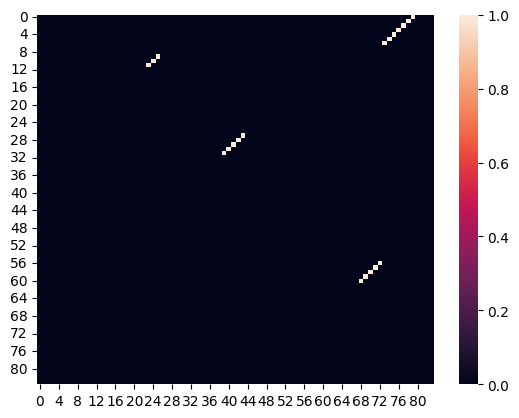

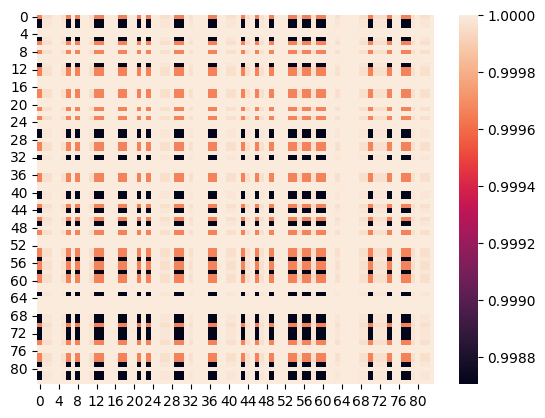

In [ ]:
model.eval()
with torch.no_grad():
    for sequence, tokenized_seq, structure, interaction_matrix, padding_mask in test_dataloader:
        print(structure)
        tokenized_seq = tokenized_seq.to(device)
        out_pairwise_structure = model(tokenized_seq)
        print(out_pairwise_structure)
        out_pairwise_structure = torch.sigmoid(out_pairwise_structure)
        print(out_pairwise_structure)

        generate_heatmap(interaction_matrix[0])
        generate_heatmap(out_pairwise_structure[0])


        break